<p align="center"> <img src="https://www.motorbiscuit.com/wp-content/uploads/2020/03/Used-Car-Dealership-Getty-5.jpg"> </p> 

# Predicting used cars prices in the Canadian market

When it comes to shopping for a used car, budget is one of the main constraints. Prices can differ for a variety of factors, and the experience is quite different than buying a new vehicle. The search process is the first step, and thanks to the internet, the buyer has access to a wealth of information and reviews. With all that said, there is virtually no way to know if an offer is **fair** or **overpriced**. In practice, *prior experience* and *extensive search* can help. How about using machine learning and data analysis to simplify the process and provide **unbiased** advice to the shopper?  
In the following notebook, I will design and present two machine learning algorithms that will predict used car prices in Canada. The same process could be followed to obtain similar prediction software for the US market.  
 First, an exploratory data analysis (EDA) will be performed on a dataset that will be downloaded from **Kaggle**. In the second step, features will be engineered to train and tune two different machine learning regression algorithms.  
 This project is part of the [Zero to Data Science Bootcamp by Jovian](https://jovian.ai/learn/zero-to-data-analyst-bootcamp).

## 1- Download used cars market data  
In this section, we will install and import all the libraries that will be used throughout the notebook. After that, a large dataset of used cars listings (from Canada and the US) will be downloaded. We will focus on the canadian data, but similar approach can be used to explore the listings from the US.

In [1]:
# download and import the libraries

!pip install opendatasets pandas numpy matplotlib seaborn tqdm sklearn xgboost  --quiet
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib
import pickle # to save the results
from tqdm.notebook import tqdm
import opendatasets as od
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (18, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

The library `OpenDataSets` by **Jovian** is a conveniant tool to get data from Kaggle. It requires a username and password from the account.

In [2]:
# download data
filepath = '.\\data\\marketcheck-automotive-data-us-canada'
url = 'https://www.kaggle.com/rupeshraundal/marketcheck-automotive-data-us-canada?select=ca-dealers-used.csv'
if not(os.path.exists(filepath)):
    od.download_kaggle_dataset(url, filepath)    

This will download two seperate `csv` files. Let's explore the `ca-dealers-used.csv` file using `Pandas`.

In [3]:
# read csv data 
canada_ds = pd.read_csv(filepath+'\\ca-dealers-used.csv', low_memory=False)
canada_ds.head(3) 

,id,vin,price,miles,stock_no,year,make,model,trim,body_type,...,drivetrain,transmission,fuel_type,engine_size,engine_block,seller_name,street,city,state,zip
0,b39ea795-eca9,19UNC1B01HY800062,179999.0,9966.0,V-P4139,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,edmundston honda,475 Rue Victoria,Edmundston,NB,E3V 2K7
1,026cb5b1-6e3e,19UNC1B02HY800023,179995.0,5988.0,PPAP70374,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,garage daniel lessard,2795 Route-du-prsident-kennedy,Notre-dame-des-pins,QC,G0M 1K0
2,5cd5d5b2-5cc2,19UNC1B02HY800071,168528.0,24242.0,B21085,2017.0,Acura,NSX,Base,Coupe,...,4WD,Automatic,Electric / Premium Unleaded,3.5,V,lougheed acura,1388 Lougheed Highway,Coquitlam,BC,V3K 6S4


Each transaction is detailled through multiple columns. The `VIN` number is unique to each car. This field will be used later to remove duplicates. Let's show the properties for each column.

In [4]:
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393603 entries, 0 to 393602
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            393603 non-null  object 
 1   vin           393603 non-null  object 
 2   price         358486 non-null  float64
 3   miles         366590 non-null  float64
 4   stock_no      365929 non-null  object 
 5   year          393586 non-null  float64
 6   make          393603 non-null  object 
 7   model         388809 non-null  object 
 8   trim          354824 non-null  object 
 9   body_type     359578 non-null  object 
 10  vehicle_type  355365 non-null  object 
 11  drivetrain    354608 non-null  object 
 12  transmission  357922 non-null  object 
 13  fuel_type     322790 non-null  object 
 14  engine_size   320950 non-null  float64
 15  engine_block  320439 non-null  object 
 16  seller_name   391371 non-null  object 
 17  street        385674 non-null  object 
 18  city

It appears that some columns lack informations for a certain number of transactions. 

In [5]:
canada_ds.isna().sum()

id                  0
vin                 0
price           35117
miles           27013
stock_no        27674
year               17
make                0
model            4794
trim            38779
body_type       34025
vehicle_type    38238
drivetrain      38995
transmission    35681
fuel_type       70813
engine_size     72653
engine_block    73164
seller_name      2232
street           7929
city             7774
state            7836
zip              7769
dtype: int64

We choose to drop all the rows missing pieces of information since we still will have a sufficient amount of data. Before that, we will drop all the columns that won't be used.

In [6]:
unused_columns = ['id', 'stock_no','seller_name', 'street', 'engine_size',
                'zip','fuel_type', 'engine_block']
canada_ds.drop(unused_columns,axis = 1, inplace=True)
canada_ds.dropna(inplace=True)

Then, we remove all duplicates using the same `vin` number.

In [7]:
canada_ds.drop_duplicates('vin', inplace=True)
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158493 entries, 0 to 393602
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           158493 non-null  object 
 1   price         158493 non-null  float64
 2   miles         158493 non-null  float64
 3   year          158493 non-null  float64
 4   make          158493 non-null  object 
 5   model         158493 non-null  object 
 6   trim          158493 non-null  object 
 7   body_type     158493 non-null  object 
 8   vehicle_type  158493 non-null  object 
 9   drivetrain    158493 non-null  object 
 10  transmission  158493 non-null  object 
 11  city          158493 non-null  object 
 12  state         158493 non-null  object 
dtypes: float64(3), object(10)
memory usage: 16.9+ MB


The resulting data frame contains more than 158000 records, with no duplicate and no missing fields. Let's display more details about the column `state`.

In [8]:
#fix state information
canada_ds.state.unique()

array(['NB', 'QC', 'BC', 'ON', 'AB', 'MB', 'SK', 'NS', 'PE', 'NL', 'YT',
       'NC', 'OH', 'SC'], dtype=object)

`OH`, `NC` and `SC` do not represent canadian provinces. To fix this problem, we display the `city` values.

In [9]:
canada_ds[canada_ds['state']=='OH']['city'].unique()

array(['Woodbridge'], dtype=object)

After some search, it turns out that *Woodbridge* is a city in Ontario. We just have to replace the values in the data frame. 

In [10]:
canada_ds['state'].replace('OH','ON',inplace=True)

We proceed the same way with `SC` and `NC`. We found that `NC` doesn't contain any record in a canadian city, and `SC` contains records in **Quebec city, QC**.

In [11]:
canada_ds.drop(index = canada_ds[canada_ds.state=='NC'].index, inplace=True)
canada_ds['state'].replace('SC','QC',inplace=True)

The column `year` provides the model year of the car. 

In [12]:
canada_ds['year'].describe()

count    158478.000000
mean       2016.341688
std           3.234555
min        1990.000000
25%        2015.000000
50%        2017.000000
75%        2019.000000
max        2022.000000
Name: year, dtype: float64

The data is a snapshot of the listings in 2021, with some cars labeled as from year 2022. This is a common practice in the automotive industry, known as the **model year**. We could create a column `age` using the data from `year`.

In [13]:
# create Age column 
canada_ds['age'] = 2022- canada_ds['year'] 

One last improvment to our data is to remove outliers, but limiting the age, price and mileage of cars.

In [14]:
# filter very expensive and very old cars (outliers)
canada_ds=canada_ds[canada_ds['age']<25]
canada_ds=canada_ds[canada_ds['price']<100000]
canada_ds=canada_ds[canada_ds['miles']<200000]
canada_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151994 entries, 16 to 393599
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   vin           151994 non-null  object 
 1   price         151994 non-null  float64
 2   miles         151994 non-null  float64
 3   year          151994 non-null  float64
 4   make          151994 non-null  object 
 5   model         151994 non-null  object 
 6   trim          151994 non-null  object 
 7   body_type     151994 non-null  object 
 8   vehicle_type  151994 non-null  object 
 9   drivetrain    151994 non-null  object 
 10  transmission  151994 non-null  object 
 11  city          151994 non-null  object 
 12  state         151994 non-null  object 
 13  age           151994 non-null  float64
dtypes: float64(4), object(10)
memory usage: 17.4+ MB


## 2- Exploratory Data Analysis

In this section, we will display some graphs to get an intuition about the data that will be used to design the prediction algorithms.

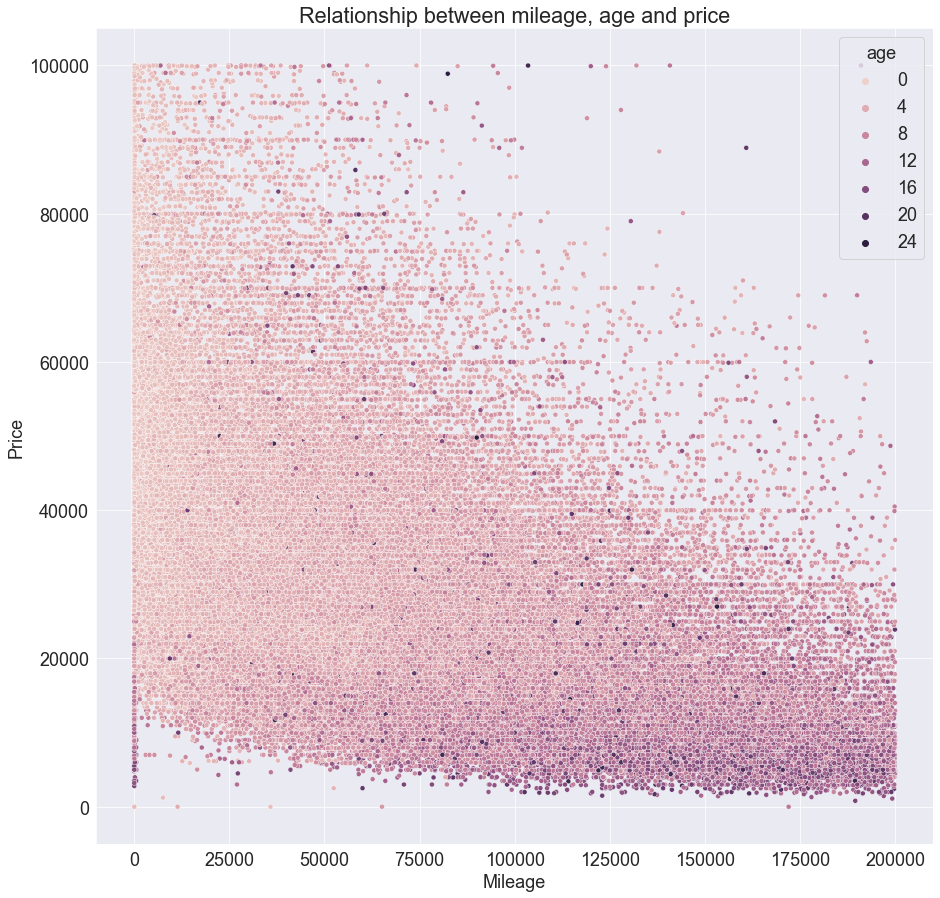

In [15]:
matplotlib.rcParams['figure.figsize'] = (15, 15)
fig = sns.scatterplot(y ='price',x='miles', hue = 'age',data =canada_ds,s=25);
fig.set(xlabel = 'Mileage', ylabel = 'Price', title = 'Relationship between mileage, age and price');

It appears that expensive cars are either recent or have low mileage. There are some exceptions (consider the dark points) where some old cars can hold a high value, regardless of the mileage.  
This next graphs show the most expensive, and the less expensive car makes in the market.

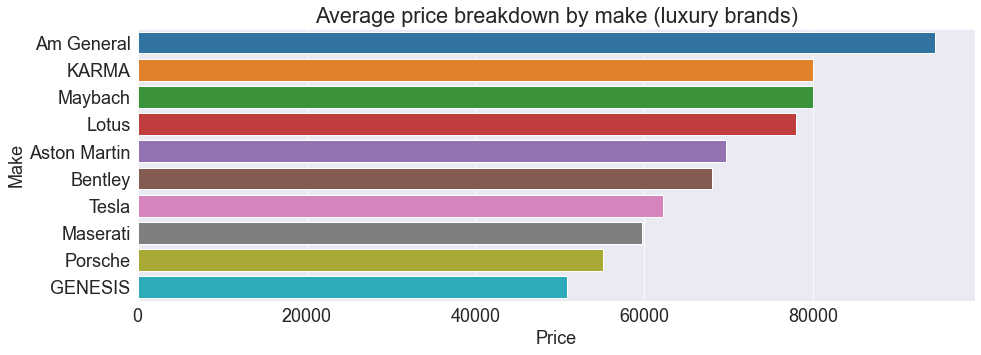

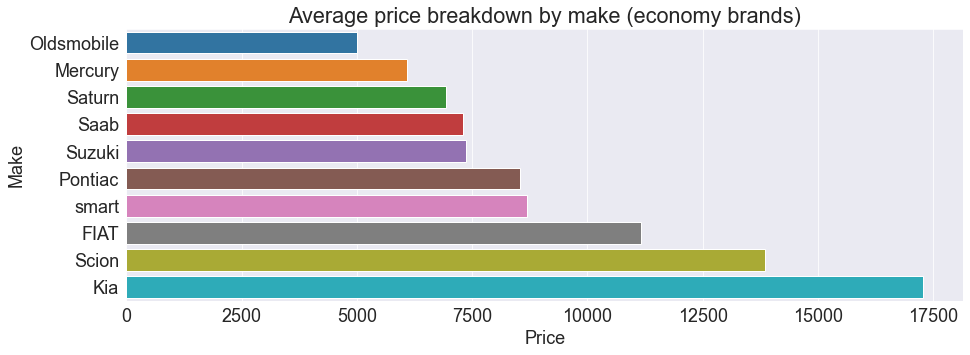

In [16]:
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (luxury brands)');
plt.figure()
matplotlib.rcParams['figure.figsize'] = (15, 5)
column = 'make'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=True).head(10)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Price', ylabel = 'Make', title = 'Average price breakdown by make (economy brands)');

Let's explore which drivetrain is more common in Canada.

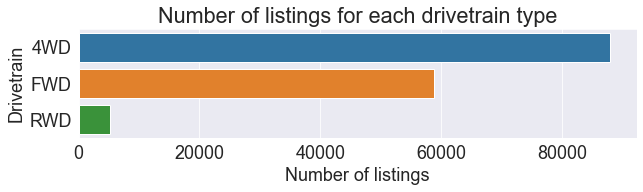

In [17]:
matplotlib.rcParams['figure.figsize'] = (10, 2)
column = 'drivetrain'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Drivetrain', title = 'Number of listings for each drivetrain type');

With no surprise, `4wd` cars are very common in Canada, due to its well-known winter!  
The next graph will show how `Automatic` transmissions are more prefered in the canadian market.

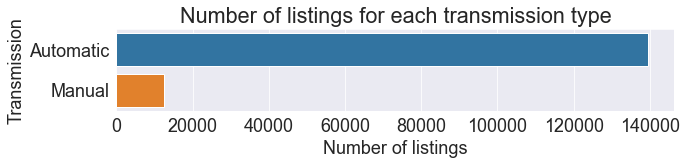

In [18]:
matplotlib.rcParams['figure.figsize'] = (10, 1.5)
column = 'transmission'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Transmission', title = 'Number of listings for each transmission type');

Used vehicles are more expensive in some provinces, due to standard of living, taxes and emission control. This is shown in the next graph.

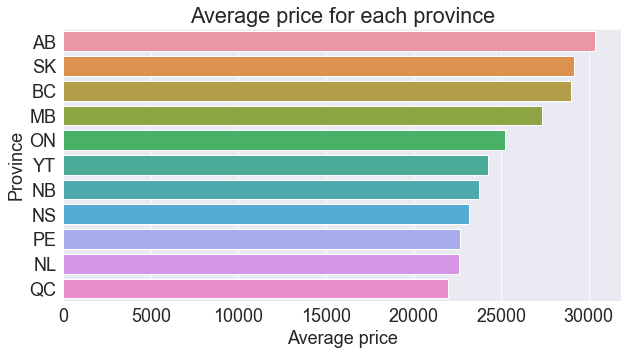

In [19]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].mean().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Average price', ylabel = 'Province', title = 'Average price for each province');

The market share of each provice is related to its population size. As we show on the next plot, Ontario has the highest number of listings (and the largest population).

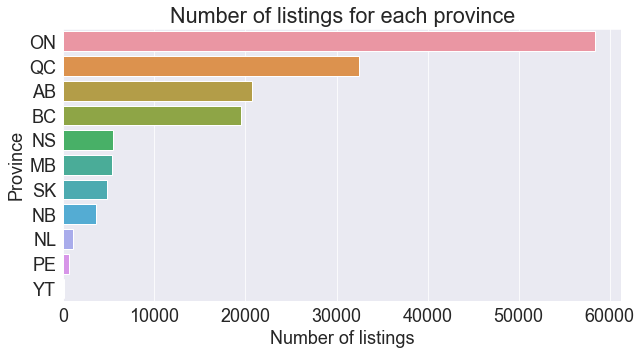

In [20]:
matplotlib.rcParams['figure.figsize'] = (10, 5)
column = 'state'
graph =  canada_ds.groupby(column)['price'].count().sort_values(ascending=False)
fig = sns.barplot(x = graph.values, y = graph.index);
fig.set(xlabel = 'Number of listings', ylabel = 'Province', title = 'Number of listings for each province');

## 3- Prepare data for machine learning

After cleaning the data, we select the most suitable features to predict/evaluate a used car price. Here is a list of available features in the dataframe: 

In [21]:
canada_ds.columns

Index(['vin', 'price', 'miles', 'year', 'make', 'model', 'trim', 'body_type',
       'vehicle_type', 'drivetrain', 'transmission', 'city', 'state', 'age'],
      dtype='object')

The output of our model will be obviously the **price**. We will not use the **VIN** number, and split the remaining features into two classes: numeric and categorical columns.  
Note that a very important piece of information is missing here: **the car condition**. In the used car market, two very identical vehicles can have large price differences due to previous maintenance, accident history, rust, and interior condition. This missing information will affect the precision of the prediction process.

In [22]:
target_cols = ['price']
features_num_cols = ['miles', 'age',]
features_cat_cols = ['make', 'model', 'drivetrain', 'transmission','state', 'city','trim','body_type','vehicle_type']

In [23]:
raw_data = canada_ds[features_num_cols+features_cat_cols+target_cols].copy()
avg_price = raw_data['price'].mean()
print('Average price is ${:.2f}'.format(avg_price))

Average price is $25771.99


The model output (*price*), has an average of $25k. The performance metrics of the regressions will be compared to this value.

First, we split the data into training, validation and testing sets.

In [24]:
# split train, test and val
# remove annoying warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import train_test_split
trainval_data, test_data = train_test_split(raw_data, test_size = 0.2)
train_data, val_data = train_test_split(trainval_data, test_size = 0.25)

The numeric features will be scaled using *scikit learn* minmax scaler.

In [25]:
# normalize numeric inputs
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_data[features_num_cols])
train_data[features_num_cols] = scaler.transform(train_data[features_num_cols])
test_data[features_num_cols] = scaler.transform(test_data[features_num_cols])
val_data[features_num_cols] = scaler.transform(val_data[features_num_cols])


The categorical features will be transformed via a one hot encoding strategy.

In [26]:
# one hot encoding categorical inputs
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(train_data[features_cat_cols])
new_one_hot_cols = list(encoder.get_feature_names(features_cat_cols))
train_data[new_one_hot_cols] = encoder.transform(train_data[features_cat_cols])
test_data[new_one_hot_cols] = encoder.transform(test_data[features_cat_cols])
val_data[new_one_hot_cols] = encoder.transform(val_data[features_cat_cols])

These transformations increase the number of features.

In [27]:
print('number of features ={}'.format(len(features_num_cols + new_one_hot_cols)))

number of features =2613


The last step will be to create input and output dataframes for each set.

In [28]:
# create input and output dataframes
train_inputs = train_data[features_num_cols + new_one_hot_cols]
test_inputs = test_data[features_num_cols + new_one_hot_cols]
val_inputs = val_data[features_num_cols + new_one_hot_cols]

train_output = train_data[target_cols]
test_output = test_data[target_cols]
val_output = val_data[target_cols]

## 4- Predicting the price using machine learning 

In this part, we will train and tune two different machine learning regression algorithms. The first method is based on gradient boosting, using the library **XGBoost**.

### 4-1 Regression using XGBoost

In [29]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor 

**XGBoost** has multiple hyperparameters. In this notebook, we will tune two parameters:
- max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- n_estimators: Number of trees. A high number of trees will most likely lead to overfitting.  

We will use a grid search method to find the optimal values of these hyperparameters.

In [ ]:
results=[]
for max_depth in tqdm(range(5,11)):
    for n_estimators in tqdm(range(50,501,50)):
        model = XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
        model.fit(train_inputs, train_output)
        train_preds = model.predict(train_inputs)
        val_preds = model.predict(val_inputs)
        error_train = mean_squared_error(train_output, train_preds, squared=False)
        error_val = mean_squared_error(val_output, val_preds, squared=False)
        print('max_depth={} **'.format(max_depth),'n_estimators={} **'.format(n_estimators),"RMS_error_train = {:.2f} ** RMS_error_val = {:.2f}".format(error_train,error_val))
        results.append([max_depth,n_estimators,error_train, error_val])

In [ ]:
with open('XGB_models','wb') as fp:
    pickle.dump(results, fp)

In [30]:
# read results from pickle file if already exists
with open('XGB_models','rb') as fp:
    results = pickle.load(fp)

The optimal values of `n_estimators` and `max_depth` are found by minimizing the validation error.

In [38]:
val_errors = [results[i][3] for i in range(len(results))]
ind_opt = np.argmin(val_errors)
print('Minimum val_error={:.2f} with n_estimators={} and max_depth={}'.format(results[ind_opt][3],results[ind_opt][1],results[ind_opt][0]))
model_opt = XGBRegressor(n_estimators=results[ind_opt][1], max_depth = results[ind_opt][0])
model_opt.fit(train_inputs,train_output)

Minimum val_error=3193.28 with n_estimators=500 and max_depth=9


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

We compare the average validation error value to the average output value:

In [32]:
print('Percentage validation error={:.2f}%'.format(100*results[ind_opt][3]/avg_price))

Percentage validation error=12.39%


12.39% error, considering that the model doesn't include any information about the condition of the vehicle, is a reasonable precision score. Let's evaluate the optimal model on the test set.

In [39]:
test_preds = model_opt.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

Percentage test error=12.54%


We obtain a similar score on the test data. Let's perform a test on a sample. This data comes from an actual transaction, where a friend purchased a used 2010 **Lexus** **RX350** on May 2021, for 15000$. 

In [47]:
# 'miles', 'age', 'make', 'model', 'drivetrain', 'transmission', 'state','city', 'trim', 'body_type', 'vehicle_type', 'price'
my_car = [150000,12,'Lexus','RX','4WD','Automatic','QC','Pointe-claire','350','SUV','Truck',14750]
sample = pd.DataFrame(columns=raw_data.columns)
sample.loc[0] = my_car
print(sample)

sample[features_num_cols] = scaler.transform(sample[features_num_cols])
sample[new_one_hot_cols] = encoder.transform(sample[features_cat_cols])
sample_inputs = sample[features_num_cols + new_one_hot_cols]
sample_output = sample[target_cols]
sample_prediction = model_opt.predict(sample_inputs)
print("listing price={:.2f}  /  predicted price={:.2f}".format(sample_output.values[0][0],sample_prediction[0]))

    miles age   make model drivetrain transmission state           city trim  \
0  150000  12  Lexus    RX        4WD    Automatic    QC  Pointe-claire  350   

  body_type vehicle_type  price  
0       SUV        Truck  14750  
listing price=14750.00  /  predicted price=13153.58


The prediction is fairly close to the price (within error margin of 12.54%).

### 4-2 Regression using a Feedforward neural network

In this section, we will implement a feedforward neural network using the API **Keras**, which is based on **Tensorflow**. The neural networks can have multiple parameters and architectures. In this article, we will test 3 different architectures. In all the implementations, we will use the early stopping callback, to prevent overfitting.  
The architectures that will be tested are: 
- 2 hidden layer of 2000 neurons (wide, shallow)
- 5 hidden layers of 2000 neurons (wide, deep)
- 10 hidden layers of 1000 neurons (narrow, deep)

In [48]:
from keras import models
from keras import layers
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10, restore_best_weights=True)


In [ ]:
network1 = models.Sequential()
network1.add(layers.Dense(2000 , activation='relu' , input_dim=len(features_num_cols + new_one_hot_cols))) 
network1.add(layers.Dense(2000 , activation='relu' )) 

network1.add(layers.Dense(1)) 

network1.compile(optimizer='Adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])
# Training 
n_epochs =10000
result1 = network1.fit(train_inputs, train_output,epochs = n_epochs,verbose=2, batch_size = 10000,
                     validation_data=(val_inputs,val_output),callbacks = [es])

In [52]:
test_preds = network1.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

ValueError: in user code:

    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1462 predict_function  *
        return step_function(self, iterator)
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1452 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1445 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\training.py:1418 predict_step
        return self(x, training=False)
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_9 is incompatible with the layer: expected axis -1 of input shape to have value 2622 but received input with shape [None, 2613]


In [ ]:
network2 = models.Sequential()
network2.add(layers.Dense(2000 , activation='relu' , input_dim=len(features_num_cols + new_one_hot_cols))) 
network2.add(layers.Dense(2000 , activation='relu' )) 
network2.add(layers.Dense(2000 , activation='relu' )) 
network2.add(layers.Dense(2000 , activation='relu' )) 
network2.add(layers.Dense(2000 , activation='relu' )) 


network2.add(layers.Dense(1)) 

network2.compile(optimizer='Adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])
# Training 
n_epochs =10000
result2 = network2.fit(train_inputs, train_output,epochs = n_epochs,verbose=2, batch_size = 10000,
                     validation_data=(val_inputs,val_output),callbacks = [es])

In [ ]:
test_preds = network2.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

In [ ]:
network3 = models.Sequential()
network3.add(layers.Dense(1000 , activation='relu' , input_dim=len(features_num_cols + new_one_hot_cols))) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 
network3.add(layers.Dense(1000 , activation='relu' )) 

network3.add(layers.Dense(1)) 

network3.compile(optimizer='Adam', loss='MeanSquaredError', metrics=['RootMeanSquaredError'])
# Training 
n_epochs =10000
result3 = network3.fit(train_inputs, train_output,epochs = n_epochs,verbose=2, batch_size = 10000,
                     validation_data=(val_inputs,val_output),callbacks = [es])

In [ ]:
test_preds = network3.predict(test_inputs)
error_test = mean_squared_error(test_output, test_preds, squared=False)
print('Percentage test error={:.2f}%'.format(100*error_test/avg_price))

## 5- Conclusion and future work